In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv("stockCase.csv")

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

In [5]:
data["Open"] = data["Open"].str.replace("[a-zA-Z]", "", regex = True)

In [6]:
data['Open'] = data['Open'].astype('float')

In [7]:
#Outlier
for column in data.columns:
    low_limit = data[column].quantile(0.25)
    high_limit = data[column].quantile(0.75)
    iqr = high_limit - low_limit
    lower_bound = low_limit - 1.5 * iqr
    upper_bound = high_limit + 1.5 * iqr
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    data = data.drop(outliers.index)

In [8]:
data['HL_PCT'] = (data['High'] - data['Low']) / data['Low'] * 100.0  # high-low percentage
data['PCT_change'] = (data['Close'] - data['Open']) / data['Open'] * 100.0  # open-close percentage

In [9]:
data.isnull().sum()

Date           0
Open          11
High           0
Low            1
Close         23
Adj Close      1
Volume         0
HL_PCT         1
PCT_change    34
dtype: int64

In [10]:
data.dropna(inplace=True)

In [11]:
cols = ['Open', 'Close', 'Volume', 'High', 'Low', 'Adj Close', 'HL_PCT', 'PCT_change']

for column in cols:
   data[column].fillna(data[column].mean(), inplace=True)

In [12]:
import matplotlib.pyplot as plt

def find_threshold(X_train, y_train, X_test, y_test, model, start=0, stop=1, step=0.05):
    thresholds = []
    accuracies = []
    for threshold in np.arange(start, stop + step, step):
        y_pred = [1 if pred > threshold else 0 for pred in model.predict(X_test)]
        accuracy = accuracy_score(y_test, y_pred)
        thresholds.append(threshold)
        accuracies.append(accuracy)
    max_accuracy = max(accuracies)
    best_threshold = thresholds[accuracies.index(max_accuracy)]
    print(f"Best Threshold: {best_threshold:.2f} | Accuracy: {max_accuracy:.2f}")
    plt.plot(thresholds, accuracies)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Threshold vs. Accuracy')
    plt.show()
    return best_threshold


In [13]:
threshold_PCT_change = 1.0
threshold_HL_PCT = 2.0

In [14]:
data['buy_signal'] = ((data['PCT_change'] < threshold_PCT_change) & (data['HL_PCT'] < threshold_HL_PCT)).astype(int)

Best Threshold: 0.05 | Accuracy: 1.00


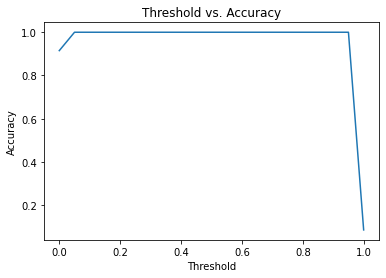

In [15]:
X = data[['HL_PCT', 'PCT_change']]
y = data['buy_signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
gbm = lgb.train(params, lgb_train, num_boost_round=100)

best_threshold = find_threshold(X_train, y_train, X_test, y_test, gbm, start=0, stop=1, step=0.05)


In [ ]:
#threshold_PCT_change = 1.0
#threshold_HL_PCT = 2.0

In [ ]:
#data['buy_signal'] = ((data['PCT_change'] < threshold_PCT_change) & (data['HL_PCT'] < threshold_HL_PCT)).astype(int)

In [22]:
#print(data)

[[1.2, 0.8]]


In [ ]:
#X = data[['HL_PCT', 'PCT_change']]
#y = data['buy_signal']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:


#lgb_train = lgb.Dataset(X_train, y_train)

#params = {
  #  'objective': 'binary',
  #  'metric': 'binary_logloss',
  #  'boosting_type': 'gbdt',
   # 'num_leaves': 31,
   # 'learning_rate': 0.05,
    #'feature_fraction': 0.9,
   # 'bagging_fraction': 0.8,
   # 'bagging_freq': 5,
   # 'verbose': -1
}

#gbm = lgb.train(params, lgb_train, num_boost_round=100)


In [ ]:
#y_pred = gbm.predict(X_test)
#y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

#accuracy = accuracy_score(y_test, y_pred)
#print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


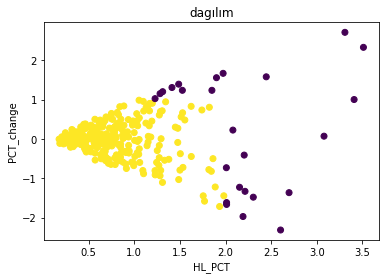

In [16]:
X = data[['HL_PCT', 'PCT_change']]
y = data['buy_signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}
gbm = lgb.train(params, lgb_train, num_boost_round=100)


y_pred = gbm.predict(X_test)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.scatter(X_test['HL_PCT'], X_test['PCT_change'], c=y_pred)
plt.xlabel('HL_PCT')
plt.ylabel('PCT_change')
plt.title("dagılım")
plt.show()


In [17]:
import joblib

# Modeli bir dosyaya kaydedelim
joblib.dump(gbm, 'model.joblib')

# Modeli dosyadan yükleyelim
gbm_loaded = joblib.load('model.joblib')


In [18]:

model = joblib.load('model.joblib')


HL_PCT = float(input("Enter the HL_PCT value: "))
PCT_change = float(input("Enter the PCT_change value: "))

data = [[HL_PCT, PCT_change]]
prediction = model.predict(data)[0]


if prediction > 0.5:
    print("This is a buyable stock")
else:
    print("This is not a buyable stock")


This is not a buyable stock
